# Higher order Sobol' indices, skewness and kurtosis indices

<h3> Nicholas Wong </h3>
<h4> University of Cambridge</h4>

In [1]:
%matplotlib inline
from equadratures import *
import numpy as np
import scipy.stats as s

In certain cases, higher order output statistical indices may need to be estimated given input PDF. While first order statistics give the fractional variance conditioned on one variable at a time, the interactions between subsets of variables are neglected. Higher order Sobol' indices address this particular issue.

Variances give the spread of the data away from the mean, but does not account for the direction of the spread and the relative weight of the tail of the distribution (the "peakiness"). The skewness and kurtosis address precisely these concerns. These measures can also be decomposed in a similar fashion to Sobol' indices, giving rise to conditional skewness and kurtosis. Individual components to the skewness and kurtosis with respect to each input variable or groups of such may be computed using the new methods in the Statistics class. 

<h2> Methodology </h2>

The computation of Sobol' indices is intuitive when conidering the computation of the global variance using PC. Due to orthogonality of the basis polynomials, the global variance is computed as:

$$ \textrm{Var}[f(x)] = \sum_{i=1}^{P} \beta_i^2, $$

where $\beta_i$'s are PC expansion coefficients, associated with a certain polynomial. A Sobol' index simply sums up the squares of cofficients corresponding to contributing polynomials (i.e. polynomials with a non-zero order in the variables concerned. Conditional skewness/kurtosis indices follow the same principle.

Skewness and kurtosis are defined as the third and fourth central standardized moment. For instance, the skewness is:

$$\mu^{3} = \int_S (f(x) - \mu)^{3} \rho ds = \int_S \left(\sum_{i=1}^P \beta_i \pi_i(x)\right)^{3} \rho ds,$$

where $\rho$ is the input PDF, defined over $S$, the support. In practice, Gauss quadrature is used to evaluate the integral numerically, and two approaches can be taken. Firstly, one can sum the polynomial evaluations, each weighted by the corresponding coefficient, at the quadrature points, resulting in a "total evaluation" at each quadrature point. Then, cube/fourth the results and compute the integral by forming the inner product with a quadrature weight vector. (effectively sum-before-integral) This approach is $O(Pd)$ where $P$ is the number of basis terms and $d$ is the input dimension. This is satisfactory for computing the global skewness/kurtosis.

However, to compute conditional indices, it is necessary to expand the inner sum using the multinomial theorem first, as only by doing so will the result be interpretable as a sum of contributions from each  (group of) basis term(s) (effectively integral-before-sum). The details of such expansion is given in Geraci et al [reference!]. With computing the variance-based Sobol' indices, the cross term conveniently cancels with orthogonality. However, with skewness and kurtosis the cross terms do not necessarily cancel. This necessitates an $O(P^3d)$ operation for skewness and $O(P^4d)$ operation for kurtosis, resulting in forbiddingly long computational times. 

However, all is not lost, and some saving may be achieved with low order conditional skewness/kurtosis terms. Firstly, Geraci et al.[reference!] details some conditions where the integral in the sum need not be computed as they are zero. Secondly, as only cross term integrals that result in the variables we are interested in need to be computed, some basis terms can be eliminated a priori. For instance, when computing first order indices, it is not necessary to consider any basis term that has total order larger than 1, since any integral with such a basis term will only increase the number of participating variables, and certainly will not contribute to the first order index at the end. This reduces the complexity to $O(n^3d)$ for skewness, for example, where $n << P$ is the highest order of the polynomial in any dimension.

<h2> Usage Example </h2>

Let's see the methods in action. First we define a test function. Taking the quadratic G-function [reference!] as an example: 

$$ f(x_0, x_1, x_2, x_3) = \prod_{i=1}^4 \frac{|4x_i - 2| + i^2}{1+i^2}. $$

In [2]:
def G_fun(x):
    f = 1.0
    for i in range(4):
        t = (np.abs(4*x[i] - 2) + i**2.0) * 1.0/(1 + i**2.0)
        f = f * t
    return f

Let's use a degree 5 tensor grid as the index set and the following input PDF:

$$ x_0, x_1, x_2, x_3 \sim \mathcal{U}(0,1)^4. $$

In [3]:
degree = 5
points_used = degree + 1
x0 = Parameter(param_type="Uniform", lower=0.0, upper=1.0, points=points_used)
x1 = Parameter(param_type="Uniform", lower=0.0, upper=1.0, points=points_used)
x2 = Parameter(param_type="Uniform", lower=0.0, upper=1.0, points=points_used)
x3 = Parameter(param_type="Uniform", lower=0.0, upper=1.0, points=points_used)
parameters = [x0,x1,x2,x3]

Calculate the polynomial coefficients and initiate Statistics class:

In [4]:
basis = IndexSet('Tensor grid',[degree,degree,degree,degree])
uqProblem = Polyint(parameters,basis)
coefficients, indices, pts = uqProblem.getPolynomialCoefficients(G_fun)
stats = Statistics(coefficients, basis, parameters)

By default, global indices (mean, variance, skewness and kurtosis) are already computed at initialization. They can be viewed through printing the corresponding class variables

In [5]:
print stats.mean
print stats.variance
print stats.skewness
print stats.kurtosis

1.03619468893
0.423001291441
0.874198787521
3.03775388049


Now sample the output distribution with Monte Carlo and compute the statistics:

In [6]:
x0_samples = x0.getSamples(100000)
x1_samples = x1.getSamples(100000)
x2_samples = x2.getSamples(100000)
x3_samples = x3.getSamples(100000)
f = np.zeros((100000,1))

for i in range(100000):
    f[i,0] = G_fun([x0_samples[i,0], x1_samples[i,0], x2_samples[i,0], x3_samples[i,0]])

print np.mean(f)
print np.var(f)
print float(s.skew(f))
print float(s.kurtosis(f, fisher = False))

1.0003033832
0.471885570482
0.688292325516
2.92393148972


As seen, the agreement is not bad. Now, let's calculate the first two orders of conditional indices.

In [7]:
v1 = stats.getSobol(1)
v2 = stats.getSobol(2)
s1 = stats.getCondSkewness(1)
s2 = stats.getCondSkewness(2)
k1 = stats.getCondKurtosis(1)
k2 = stats.getCondKurtosis(2)

Here, the keys of each dict signify the dimensions involved in the index. Let's examine the sum of the indices in these two orders:

In [8]:
print sum(v1.values()) + sum(v2.values())
print sum(s1.values()) + sum(s2.values())
print sum(k1.values()) + sum(k2.values())

0.999175600763
0.962874587829
0.89419000212


As seen, the sums are close to one, so we don't miss much by not evaluating the rest of the indices (which could take a long time).

We may put these values in more context by calculating the Total Sensitivity Index [reference!] of each dimension:

$$ \textrm{TSI}^a_j = \sum_{\textbf{m}\in V_j} s^{SI}_\textbf{m}, $$

where $V_j$ denotes the set of multi-indices $\textbf{m}$ that contains the dimension concerned, $j$. This can be applied to variance ($a = v$), skewness ($a = s$) and kurtosis ($a = k$). In our case, for example, we approximate:

$$ \textrm{TSI}^v_0 = \texttt{v1[(0)] + v2[(0,1)] + v2[(0,2)] + v2[(0,3)] } $$

In [9]:
print stats.calc_TSI([v1,v2])
print stats.calc_TSI([s1,s2])
print stats.calc_TSI([k1,k2])

[ 0.77715308  0.23639978  0.04004516  0.01008302]
[ 0.90833698  0.66941268  0.12475714  0.03166169]
[ 0.85915885  0.54439872  0.08897176  0.02198146]


The results agree with the fact about the G-function, that the larger $i$ is the lower the conditional index will be, and offers a quantitative measure of how important the variable is: the higher the index, the more important it is. This type of analysis can be applied to dimensional reduction applications to prune unnecessary variables. They also agree somewhat with Geraci et al., but with some discrepancies (possibly due to the index set used).

Finally, we can visualize the results with a bar plot:

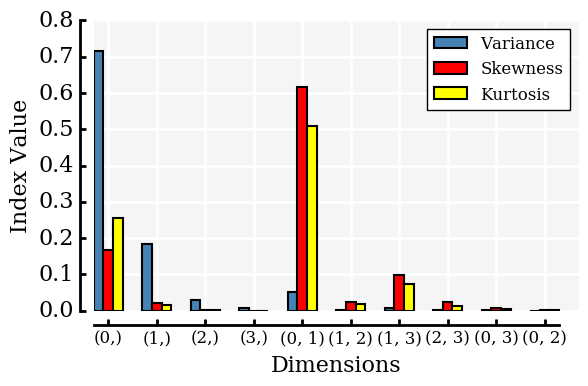

In [10]:
v = v1.copy()
s = s1.copy()
k = k1.copy()
v.update(v2)
s.update(s2)
k.update(k2)

stats.plot_all_indices([v,s,k])